# Модуль 3: Инструмент разметки данных

**Цель:** Подготовить данные для ручной разметки аннотатором,
экспортировать их в CSV и затем проверить качество полученной разметки
с использованием контрольных примеров и метрики Cohen's Kappa.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import cohen_kappa_score, confusion_matrix, classification_report
import os

from inject_tests import inject_test_cases

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
sns.set(style="whitegrid")
np.random.seed(42)

INPUT_CLEAN_DATA_PATH = '../data/clean_median_imputed_clip.csv'
DATA_TO_LABEL_PATH = '../data/data_to_label.csv'
LABELED_DATA_PATH = '../data/data_labeled.csv'
FIGURES_DIR = 'figures'

if not os.path.exists('../data'):
    os.makedirs('../data')
if not os.path.exists(FIGURES_DIR):
    os.makedirs(FIGURES_DIR)

## Шаг 1: Подготовка данных для разметки

1. Загружаем очищенный датасет (`clean_median_imputed_clip.csv`).
2. Добавляем 10 контрольных строк (5 "счастливых", 5 "несчастливых") с помощью `inject_tests.py`.
3. Удаляем колонку `Ladder score`, чтобы аннотатор не мог ее использовать.
4. Сохраняем результат в `data_to_label.csv`.

In [ ]:
df_clean = pd.read_csv(INPUT_CLEAN_DATA_PATH)
print(f"Загружен очищенный датасет: {INPUT_CLEAN_DATA_PATH}, размер: {df_clean.shape}")

if 'ladder' not in df_clean.columns:
    raise ValueError("'ladder' column not found in the input dataset. Cannot create test cases.")

is_happy_condition = lambda score: score >= 6.0

df_for_labeling, test_mask_injected = inject_test_cases(
    df_clean,
    target_col='ladder',
    condition_func=is_happy_condition,
    n_positive=5,
    n_negative=5,
    random_state=42
)

columns_to_show = [col for col in df_for_labeling.columns if col not in ['ladder', '__test_id', '__is_control']]

df_to_export = df_for_labeling[columns_to_show]

df_to_export.to_csv(DATA_TO_LABEL_PATH, index=False)
print(f"Данные для разметки сохранены в: {DATA_TO_LABEL_PATH}")
print(f"Количество строк для разметки: {len(df_to_export)}")
print("Пример данных для разметки:")
display(df_to_export.head())

df_with_true_labels = df_for_labeling.copy()
df_with_true_labels['__true_happy_label'] = df_with_true_labels['ladder'].apply(is_happy_condition).astype(int)

Загружен очищенный датасет: ../data/clean_median_imputed_clip.csv, размер: (143, 6)
Добавлено 10 контрольных строк (5 позитивных, 5 негативных).
Данные для разметки сохранены в: ../data/data_to_label.csv
Количество строк для разметки: 153
Пример данных для разметки:


/Users/nurkaevshamil/Documents/data_for_ml/data_for_ml_course/03_data_labeling/inject_tests.py:71: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_with_tests["__is_control"] = df_with_tests["__is_control"].fillna(False)


,country,region,iso3,year,gdp
0,Algeria,Middle East and North Africa,DZA,2015.0,13434.0
1,Albania,Central and Eastern Europe,ALB,2015.0,10620.0
2,Turkiye,Middle East and North Africa,TUR,2015.0,19360.0
3,Benin,Sub-Saharan Africa,BEN,2015.0,1830.0
4,Singapore,Southeast Asia,SGP,2015.0,80794.0


## Шаг 2: Инструкция для аннотатора

1.  Откройте файл `../data/data_to_label.csv`.
2.  Ознакомьтесь с Техническим Заданием (`label_spec.md`).
3.  Для каждой строки добавьте колонку `is_happy` и проставьте в ней `1` (если считаете страну счастливой) или `0` (если несчастливой), основываясь на вашем суждении и данных в других колонках.
4.  **Важно:** Не оставляйте пропусков в колонке `is_happy`. Порядок строк должен быть сохранен.
5.  Сохраните размеченный файл как `../data/data_labeled.csv`.

---

**<ОЖИДАНИЕ РАЗМЕТКИ>**

---

*После того как файл `../data/data_labeled.csv` будет создан аннотатором, выполните ячейки ниже.*

## Шаг 3: Загрузка и проверка разметки аннотатора

1. Загружаем файл `data_labeled.csv`.
2. Проверяем наличие колонки `is_happy`, отсутствие в ней NaN и соответствие количества строк.
3. Считаем согласованность разметки (Cohen's Kappa) на контрольных строках.
4. Визуализируем распределение меток.

Загружен размеченный файл: ../data/data_labeled.csv, размер: (153, 6)
Cohen's Kappa на контрольных строках: 1.0000
Ошибок на контрольных строках: 0 из 10 (0.00%)
Матрица ошибок на контрольных строках (True vs Annotator):
[[5 0]
 [0 5]]


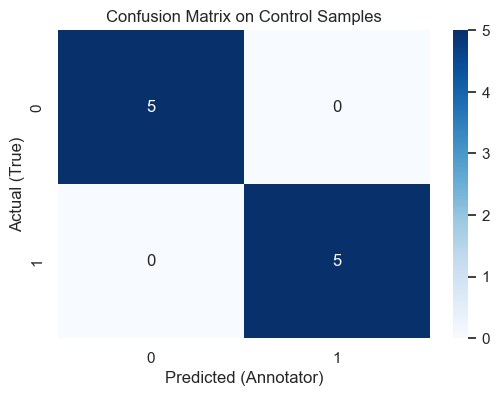

Отчет по классификации на контрольных строках:
               precision    recall  f1-score   support

Not Happy (0)       1.00      1.00      1.00         5
    Happy (1)       1.00      1.00      1.00         5

     accuracy                           1.00        10
    macro avg       1.00      1.00      1.00        10
 weighted avg       1.00      1.00      1.00        10



/var/folders/f6/chb_xqws4hj342hbxtjqschh0000gn/T/ipykernel_31370/1154227243.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='is_happy', data=df_labeled, palette='viridis')


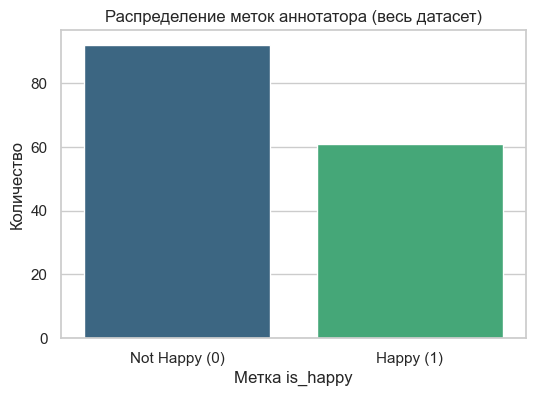

In [4]:
df_labeled = pd.read_csv(LABELED_DATA_PATH)
print(f"Загружен размеченный файл: {LABELED_DATA_PATH}, размер: {df_labeled.shape}")

if 'is_happy' not in df_labeled.columns:
    raise ValueError("Колонка 'is_happy' отсутствует в размеченном файле.")
if df_labeled['is_happy'].isnull().any():
    raise ValueError("В колонке 'is_happy' присутствуют пропущенные значения (NaN).")
if not pd.api.types.is_numeric_dtype(df_labeled['is_happy']):
    try:
        df_labeled['is_happy'] = df_labeled['is_happy'].astype(int)
    except ValueError:
        raise TypeError("Тип данных колонки 'is_happy' не является числовым (ожидается 0 или 1).")
if not df_labeled['is_happy'].isin([0, 1]).all():
    raise ValueError("Значения в колонке 'is_happy' должны быть только 0 или 1.")


if 'df_with_true_labels' not in locals():
        df_clean_reloaded = pd.read_csv(INPUT_CLEAN_DATA_PATH)
        df_for_labeling_reloaded, _ = inject_test_cases(
            df_clean_reloaded, target_col='Ladder score', condition_func=lambda s: s >= 6.0, random_state=42
        )
        df_with_true_labels = df_for_labeling_reloaded.copy()
        df_with_true_labels['__true_happy_label'] = df_with_true_labels['Ladder score'].apply(lambda s: s >= 6.0).astype(int)
        print("Перезагружен исходный датасет с контрольными метками для проверки.")


if len(df_labeled) != len(df_with_true_labels):
    print(f"Предупреждение: Количество строк в размеченном файле ({len(df_labeled)}) не совпадает с ожидаемым ({len(df_with_true_labels)}). Возможны проблемы при расчете каппы.")
    kappa = np.nan
    report = "N/A (количество строк не совпадает)"
    errors_on_test = -1
    total_test = -1

else:
    df_check = df_with_true_labels.copy()
    df_check['annotator_label'] = df_labeled['is_happy'].values

    control_rows = df_check[df_check['__is_control']].copy()

    if control_rows.empty:
        print("Не найдены контрольные строки для расчета каппы.")
        kappa = np.nan
        report = "N/A (контрольные строки не найдены)"
        errors_on_test = -1
        total_test = -1
    else:
        true_control_labels = control_rows['__true_happy_label']
        annotator_control_labels = control_rows['annotator_label']

        # Cohen's Kappa
        kappa = cohen_kappa_score(true_control_labels, annotator_control_labels)
        print(f"Cohen's Kappa на контрольных строках: {kappa:.4f}")

        # Подсчет ошибок на контрольных строках
        errors_on_test = (true_control_labels != annotator_control_labels).sum()
        total_test = len(control_rows)
        error_rate = errors_on_test / total_test if total_test > 0 else 0
        print(f"Ошибок на контрольных строках: {errors_on_test} из {total_test} ({error_rate:.2%})")

        # Матрица ошибок и отчет
        print("Матрица ошибок на контрольных строках (True vs Annotator):")
        cm = confusion_matrix(true_control_labels, annotator_control_labels)
        print(cm)

        # Визуализация матрицы ошибок
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
        plt.xlabel('Predicted (Annotator)')
        plt.ylabel('Actual (True)')
        plt.title('Confusion Matrix on Control Samples')
        plt.savefig(os.path.join(FIGURES_DIR, 'confusion_matrix_control.png'))
        plt.show()


        print("Отчет по классификации на контрольных строках:")
        report = classification_report(true_control_labels, annotator_control_labels, target_names=['Not Happy (0)', 'Happy (1)'])
        print(report)

        # Строки с ошибками на контрольных примерах
        error_indices = control_rows.index[true_control_labels != annotator_control_labels]
        if not error_indices.empty:
            print("Примеры ошибок на контрольных строках:")
            display(control_rows.loc[error_indices, ['Country name', '__true_happy_label', 'annotator_label']])


# Визуализация распределения меток аннотатора по всему датасету
plt.figure(figsize=(6, 4))
sns.countplot(x='is_happy', data=df_labeled, palette='viridis')
plt.title('Распределение меток аннотатора (весь датасет)')
plt.xlabel('Метка is_happy')
plt.ylabel('Количество')
plt.xticks([0, 1], ['Not Happy (0)', 'Happy (1)'])
plt.savefig(os.path.join(FIGURES_DIR, 'annotator_labels_distribution.png'))
plt.show()


quality_metrics = {
    'kappa': kappa if 'kappa' in locals() else np.nan,
    'errors_on_test': errors_on_test if 'errors_on_test' in locals() else -1,
    'total_test': total_test if 'total_test' in locals() else -1
}

**Выводы по качеству разметки:**
* Cohen's Kappa = [значение] указывает на [интерпретация уровня согласованности: плохой, слабый, умеренный, хороший, отличный].
* Процент ошибок на контрольных примерах = [значение]%.
* [Дополнительные выводы на основе матрицы ошибок или конкретных примеров ошибок].

*(Заполнить после выполнения ячейки выше)*